In [11]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
from matplotlib.patches import Polygon
from matplotlib.ticker import AutoMinorLocator

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.nsidc import download_is2, read_atl03

69.01888751162573 -49.04438938557605
2019-06-17T06:45:19Z
ATL03_20190617064249_12220303_006_02.h5
1222
gt2l
  reading in data/atl03_raw/ATL03_20190617064249_12220303_006_02_gt2l_0019.h5
  reading in beam: gt2l  --> done.


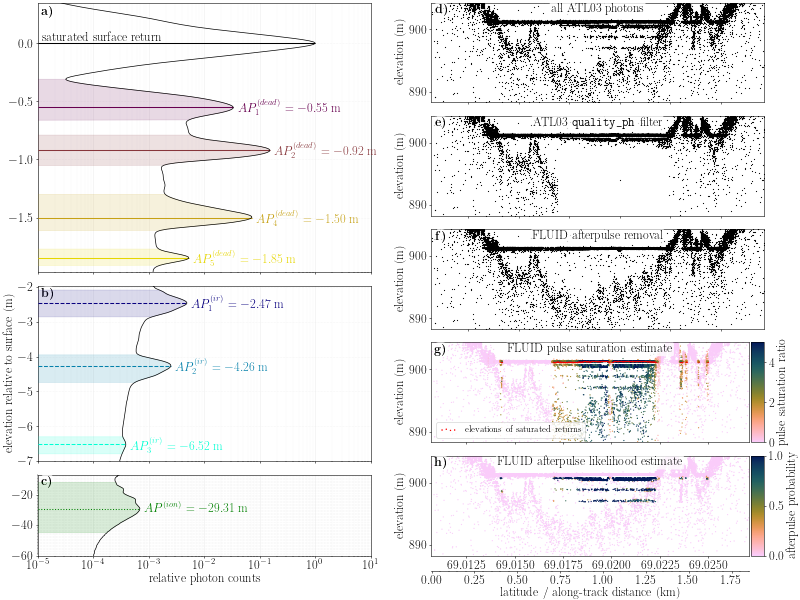

In [18]:
df = pd.read_csv('data/saturation_counts_alldata_wider.csv')

plt.rcParams.update({
    'font.size': 18,
    'text.usetex': True,
    'font.family': 'Optima'
})

thresh_upper = 0.35
thresh_mid = -1.97
thresh_lower = -7
thresh_tail = -60.0

peak_target_elevs = [0.0, -0.55, -0.92, -1.50, -1.85, -2.47, -4.26, -6.52]
peak_elevs_dict = {
    'all':    [0.0,  -0.55,  -0.92, np.nan,  -1.50,  -1.85,  -2.47,  -4.26,  -6.52, -29.31],
    'strong': [0.0,  -0.55,  -0.92, np.nan,  -1.48, np.nan,  -2.44,  -4.23,  -6.46, -29.05],
    'weak':   [0.0,  -0.53, -0.946, np.nan,  -1.50,  -1.85,  -2.49,  -4.42, -6.605, -29.34],
    '1':      [0.0,  -0.54,  -0.88, np.nan,  -1.40, np.nan,  -2.37,  -4.19,  -6.44, -28.68],
    '2':      [0.0,  -0.51,  -0.88, np.nan,  -1.43, np.nan,  -2.31,  -4.24,  -6.52, -30.54],
    '3':      [0.0,  -0.56,  -0.92,  -1.22,  -1.50, -1.795,  -2.47,  -4.24,  -6.46, -29.27],
    '4':      [0.0, -0.575, -0.946, np.nan,  -1.50,  -1.85,  -2.50,  -4.45,  -6.65, -29.33],
    '5':      [0.0,  -0.54,  -0.89, np.nan, np.nan, np.nan,  -2.35,  -4.21,  -6.47, -28.99],
    '6':      [0.0,  -0.55,  -0.95, np.nan, -1.484,  -1.82,  -2.38,  -4.25,  -6.53, -30.61],
}
peak_starts = [0.0, -0.31, -0.79, np.nan, -1.30, -1.77, -2.09, -3.95, -6.3]
peak_ends = [0.0, -0.67, -1.06, np.nan, -1.62, -1.92, -2.87, -4.75, -6.8]
# lower internal reflection and PMT ionization: -6.52, -29.31
peak_labels = ['surface'] + [r'$AP_%i^{(dead)}=' % (i+1) for i in range(5)] + [r'$AP_%i^{(ir)}=' % (i+1) for i in range(3)]
widths_pk = [0.0, 0.18, 0.15, 0.1, 0.11, 0.1, 0.35, 0.35, 0.2, 17.0]
cols_pk = ['black','#67004F', '#87363B', '#A76B28', '#C6A114', '#E6D600', '#08007F', '#0480AA', '#00FFD4', 'green']
lsty_pk = ['-', '-', '-', '-', '-', '-', '--', '--', '--', ':']

# for j, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
beam_select = 'all'

fig = plt.figure(figsize=[16, 12], dpi=50)
gs = fig.add_gridspec(30, 2)
ax = fig.add_subplot(gs[:15, 0])
ax1 = fig.add_subplot(gs[15:25, 0], sharex=ax)
ax2 = fig.add_subplot(gs[25:, 0], sharex=ax)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
axs = [ax, ax1, ax2]
for i in range(5):
    if i == 0:
        axs.append(fig.add_subplot(gs[i*6:(i+1)*6, 1]))
    else:
        axs.append(fig.add_subplot(gs[i*6:(i+1)*6, 1],sharex=axs[-1]))
    if i < 4:
        plt.setp(axs[-1].get_xticklabels(), visible=False)
xlim_ax = (1e-5,10)

vals = df['smooth_%s'%beam_select]
peak_target_elevs = peak_elevs_dict[str(beam_select)]

##############################################################    
ax.plot(vals, df.elev_bins, 'k-', lw=1, zorder=1000)
for i in np.arange(0,6):
    thish = peak_target_elevs[i]
    if not np.isnan(thish):
        thispeak_height = vals.iloc[np.argmin(np.abs(df.elev_bins-thish))]
        ax.plot([xlim_ax[0], thispeak_height], [thish]*2, color=cols_pk[i], ls=lsty_pk[i], zorder=100,solid_capstyle='butt')
        if i == 0:
            ax.text(1.2*xlim_ax[0], thish, 'saturated surface return', color=cols_pk[i], ha='left', va='bottom')
        else:
            ax.text(thispeak_height*1.2, thish, r'%s%.2f$ m' % (peak_labels[i],thish), color=cols_pk[i], weight='bold', va='center')
            if beam_select == 'all':
                u = peak_starts[i]
                l = peak_ends[i]
            else:
                u = thish + widths_pk[i]
                l = thish - widths_pk[i]
            ys = [u, l] + list(df.elev_bins[(df.elev_bins <= u) & (df.elev_bins >= l)]) + [u]
            xs = [1e-12, 1e-12] +  list(vals[(df.elev_bins <= u) & (df.elev_bins >= l)]) + [1e-12]
            ax.add_patch(Polygon(np.transpose(np.vstack((xs,ys))), color=cols_pk[i], alpha=0.15,zorder=50))

if type(beam_select) == str:
    tit = '%s beams' % beam_select
else:
    tit = 'beam %i' % beam_select
if j != 0:
    ax.set_title(tit)

#ax.set_ylabel('elevation relative to surface (m)')
ax.set_xlim(xlim_ax)
ylms = (thresh_mid, thresh_upper)
ax.set_ylim(ylms)
ax.set_xscale('log')
ax.axes.yaxis.grid(which='major', color='#EEEEEE', linestyle=':', linewidth=0.8, zorder=-1000)
ax.axes.xaxis.grid(which='major', color='#EEEEEE', linewidth=0.8, zorder=-1000)
ax.axes.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5, zorder=-1000)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

##############################################################
ax1.plot(vals, df.elev_bins, 'k-', lw=1, zorder=1000)
for i in np.arange(6,9):
    thish = peak_target_elevs[i]
    if not np.isnan(thish):
        thispeak_height = vals.iloc[np.argmin(np.abs(df.elev_bins-thish))]
        ax1.plot([xlim_ax[0], thispeak_height], [thish]*2, color=cols_pk[i], ls=lsty_pk[i], zorder=100,solid_capstyle='butt')
        ax1.text(thispeak_height*1.2, thish, r'%s%.2f$ m' % (peak_labels[i],thish), color=cols_pk[i], weight='bold', va='center')
        if beam_select == 'all':
            u = peak_starts[i]
            l = peak_ends[i]
        else:
            u = thish + widths_pk[i]
            l = thish - widths_pk[i]
        ys = [u, l] + list(df.elev_bins[(df.elev_bins <= u) & (df.elev_bins >= l)]) + [u]
        xs = [1e-12, 1e-12] +  list(vals[(df.elev_bins <= u) & (df.elev_bins >= l)]) + [1e-12]
        ax1.add_patch(Polygon(np.transpose(np.vstack((xs,ys))), color=cols_pk[i], alpha=0.15,zorder=50))

ax1.set_ylabel('elevation relative to surface (m)')
ax1.set_xlim(xlim_ax)
ylms = (thresh_lower, thresh_mid)
ax1.set_ylim(ylms)
ax1.set_xscale('log')
ax1.axes.yaxis.grid(which='major', color='#EEEEEE', linestyle=':', linewidth=0.8, zorder=-1000)
ax1.axes.xaxis.grid(which='major', color='#EEEEEE', linewidth=0.8, zorder=-1000)
ax1.axes.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5, zorder=-1000)
        
##############################################################
ax2.plot(vals, df.elev_bins, 'k-', lw=1, zorder=1000)
u = -12
l = -45
ys = [u, l] + list(df.elev_bins[(df.elev_bins <= u) & (df.elev_bins >= l)]) + [u]
xs = [1e-12, 1e-12] +  list(vals[(df.elev_bins <= u) & (df.elev_bins >= l)]) + [1e-12]
ax2.add_patch(Polygon(np.transpose(np.vstack((xs,ys))), color='g', alpha=0.15,zorder=50))
thish = peak_target_elevs[9]
thispeak_height = vals.iloc[np.argmin(np.abs(df.elev_bins-thish))]
ax2.plot([xlim_ax[0], thispeak_height], [thish]*2, color='g', ls=':', zorder=100,solid_capstyle='butt')
ax2.text(thispeak_height*1.2, thish, r'$AP^{(ion)}=%.2f$ m' % thish, color='g', weight='bold', va='center')

ax2.set_xlabel('relative photon counts')
ylms = (thresh_tail, thresh_lower)
ax2.set_ylim(ylms)
ax2.yaxis.set_minor_locator(AutoMinorLocator(20))
ax2.axes.yaxis.grid(which='both', color='#EEEEEE', linestyle=':', linewidth=0.8, zorder=-1000)
ax2.axes.xaxis.grid(which='major', color='#EEEEEE', linewidth=0.8, zorder=-1000)
ax2.axes.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5, zorder=-1000)
#ax2.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

# ax.set_title(tit)

files = [
    'data/lakes/lake_09909316_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2r_0020.h5',
    'data/lakes/lake_09879690_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt2l_0019.h5',
    'data/lakes/lake_09943900_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190822162310_08490405_006_02_gt2l_0001.h5',
]
fn = files[1]
lk = dictobj(read_melt_lake_h5(fn))

print(lk.lat, lk.lon)
print(lk.time_utc)
print(lk.granule_id)
print(lk.rgt)
print(lk.gtx)

df = lk.photon_data
df['pulseid'] = df.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
df_mframe = lk.mframe_data
xatcmin = df.xatc.min()
df.xatc -= xatcmin
surf_elev = lk.surface_elevation
latmin = df.lat.min()
latmax = df.lat.max()
lonmin = df.lon.min()
lonmax = df.lon.max()
thisdate = lk.time_utc[:10]
rgt = lk.rgt
gtx = lk.gtx

# download ATL03 data from NSIDC
atl03_dir = 'data/atl03_raw'
fn_atl03 = atl03_dir + '/' + fn[fn.find('ATL03_'):]
if not os.path.isfile(fn_atl03):
    bbox = [lonmin, latmin, lonmax, latmax]
    granule_list = download_is2(start_date=thisdate, end_date=thisdate, rgt=rgt, boundbox=bbox, output_dir='data/atl03_raw')
    for gran in granule_list:
        if lk.granule_id[:30] in gran:
            thisfile = atl03_dir + '/processed_' + gran
            break
    os.rename(thisfile, fn_atl03)

beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
df03 = dfs[gtx]

ylms = np.array((-1.7*lk.max_depth, 0.4*lk.max_depth)) + surf_elev
xlms = (df.lat.min(), df.lat.max())

# fig, axs = plt.subplots(figsize=[6, 10], dpi=100, nrows=5, ncols=1, sharex=True)

txt_y = 0.9
boxprops = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none', pad=0.1)
sz = 0.5

ax = axs[-5]
ax.scatter(df.lat, df.h, s=sz, c='k', alpha=1)
ax.text(0.5, txt_y, 'all ATL03 photons', transform=ax.transAxes, bbox=boxprops, ha='center')
# ax.set_title('all ATL03 photons')

ax = axs[-4]
dfs3 = df03[df03.qual == 0]
ax.scatter(dfs3.lat, dfs3.h, s=sz, c='k')
ax.text(0.5, txt_y, r'ATL03 \texttt{quality_ph} filter', transform=ax.transAxes, bbox=boxprops, ha='center')
#ax.set_title(r'filtered by \texttt{quality_ph}')

ax = axs[-3]
df['remove_afterpulse'] = df.prob_afterpulse > np.random.uniform(0,1,len(df))
dfp = df[~df.remove_afterpulse]
scatt = ax.scatter(dfp.lat, dfp.h, s=sz, c='k', alpha=1)
# ax.set_title('data with afterpulses removed')
ax.text(0.5, txt_y, r'FLUID afterpulse removal', transform=ax.transAxes, bbox=boxprops, ha='center')

ax = axs[-2]
df_sat = df.sort_values(by='sat_ratio')
scatt = ax.scatter(df_sat.lat, df_sat.h, s=sz, alpha=1, c=df_sat.sat_ratio, cmap=cmc.batlow_r, vmin=0, vmax=5)
dfpulse = df.groupby('pulseid').median()
dfpulse = dfpulse[dfpulse.sat_ratio > 1.0]
satelevs = ax.scatter(dfpulse.lat, dfpulse.sat_elev, s=0.5, c='r', alpha=0.3, label='elevations of saturated returns')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('pulse saturation ratio')
# ax.set_title('level of pulse saturation')
ax.text(0.5, txt_y, r'FLUID pulse saturation estimate', transform=ax.transAxes, bbox=boxprops, ha='center')
satelevs = ax.scatter(-9999, -9999, s=1, c='r', alpha=1, label='elevations of saturated returns')
ax.legend(handles=[satelevs], loc='lower left', fontsize=13, scatterpoints=4)

ax = axs[-1]
df_prob = df.sort_values(by='prob_afterpulse')
scatt = ax.scatter(df_prob.lat, df_prob.h, s=sz, alpha=1, c=df_prob.prob_afterpulse, cmap=cmc.batlow_r, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('afterpulse probability')
# ax.set_title('likelihood of afterpulse photons')
ax.text(0.5, txt_y, r'FLUID afterpulse likelihood estimate', transform=ax.transAxes, bbox=boxprops, ha='center')
ymin, ymax = ax.get_ylim()
mframe_bounds_xatc = np.array(list(df_mframe['xatc_min']) + [df_mframe['xatc_max'].iloc[-1]]) - xatcmin
for xmframe in mframe_bounds_xatc:
    ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

for ax in axs[-5:]:
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    ax.set_ylabel('elevation (m)')
    
axs[4].ticklabel_format(useOffset=False, style='plain')
axs[4].tick_params(axis='x', labelsize=10)

df['x10'] = np.round(df.xatc, -1)
gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

# flip x-axis if track is descending, to make along-track distance go from left to right
if gt.lat.iloc[0] > gt.lat.iloc[-1]:
    for axx in axs[-5:]:
        axx.set_xlim(np.flip(np.array(xlms)))

# add along-track distance
lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
_lat = np.array(lx.lat)
_xatc = np.array(lx.x10) / 1e3
def lat2xatc(l):
    return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
def xatc2lat(x):
    return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
secax = ax.secondary_xaxis(-0.15, functions=(lat2xatc, xatc2lat))
secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
secax.tick_params(axis='both', which='major')
secax.ticklabel_format(useOffset=False, style='plain')

for i, ax in enumerate(axs):
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + i), transform=ax.transAxes, ha='left', va='top', fontsize=18,
           bbox=dict(facecolor='white', alpha=0.75, boxstyle='round,pad=.1,rounding_size=0.5', lw=0))

fig.tight_layout(pad=0.2)

plt.savefig('plots/afterpulses_combined.jpg', dpi=600)

In [14]:
peak_elevs_dict = {
    'all':    [0.0,  -0.55,  -0.92, np.nan,  -1.50,  -1.85,  -2.47,  -4.26,  -6.52, -29.31],
    'strong': [0.0,  -0.55,  -0.92, np.nan,  -1.48, np.nan,  -2.44,  -4.23,  -6.46, -29.05],
    'weak':   [0.0,  -0.53, -0.946, np.nan,  -1.50,  -1.85,  -2.49,  -4.42, -6.605, -29.34],
    '1':      [0.0,  -0.54,  -0.88, np.nan,  -1.40, np.nan,  -2.37,  -4.19,  -6.44, -28.68],
    '2':      [0.0,  -0.51,  -0.88, np.nan,  -1.43, np.nan,  -2.31,  -4.24,  -6.52, -30.54],
    '3':      [0.0,  -0.56,  -0.92,  -1.22,  -1.50, -1.795,  -2.47,  -4.24,  -6.46, -29.27],
    '4':      [0.0, -0.575, -0.946, np.nan,  -1.50,  -1.85,  -2.50,  -4.45,  -6.65, -29.33],
    '5':      [0.0,  -0.54,  -0.89, np.nan, np.nan, np.nan,  -2.35,  -4.21,  -6.47, -28.99],
    '6':      [0.0,  -0.55,  -0.95, np.nan, -1.484,  -1.82,  -2.38,  -4.25,  -6.53, -30.61],
}

In [82]:
from scipy.signal import find_peaks, peak_widths
hs = df.elev_bins
sel = hs < -0.3
# hs = hs[sel]
# vals = vals[sel]
vals[vals==0] = 1e-4
clog = np.log10(vals)
clog[~sel] = -3.2
pks, prps = find_peaks(clog, distance=10, prominence=0.05, width=None, wlen=None, rel_height=0.1)
wds = peak_widths(clog, pks, rel_height=0.8)

In [83]:
el_pk = np.array(hs[pks])
h_pk  = np.array(clog[pks])

In [84]:
li = list(np.round(wds[2]).astype(np.int32))
lb = np.array(hs[li])
lb_h = np.array(clog[li])
ui = list(np.round(wds[3]).astype(np.int32))
ub = np.array(hs[ui])
ub_h = np.array(clog[ui])

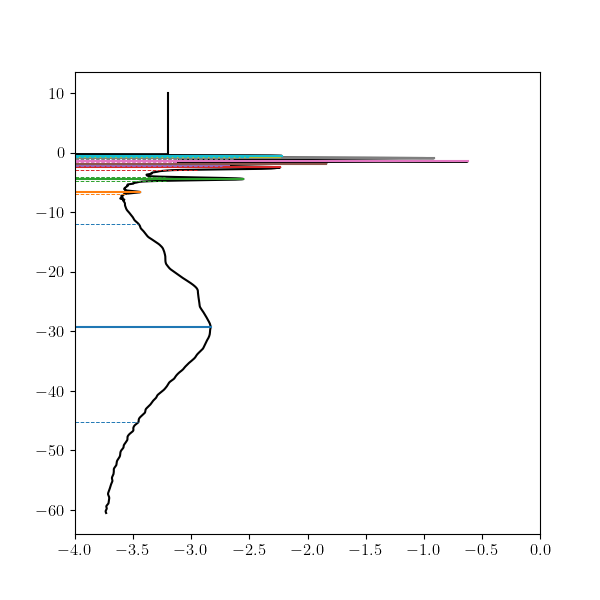

In [85]:
fig,ax = plt.subplots(figsize=[6, 6], dpi=100)
ax.plot(clog, hs, 'k-')
ax.set_xlim((-4, 0))
for j, el in enumerate(el_pk):
    ax.plot([-4, h_pk[j]], [el]*2, ls='-', c='C%i'%j)
    ax.plot([-4, lb_h[j]], [lb[j]]*2, ls='--', lw=0.7, c='C%i'%j)
    ax.plot([-4, ub_h[j]], [ub[j]]*2, ls='--', lw=0.7, c='C%i'%j)